In [3]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
import matplotlib.pyplot as plt
import bagnets.pytorchnet
from bagnets.utils import plot_heatmap, generate_heatmap_pytorch

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


In [4]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = './CS229-final-project/'

In [5]:
model_name = "bagnet33"

In [6]:
# Number of classes in the dataset
num_classes = 5

# Batch size for training (standardized to BagNet baseline)
batch_size = 256 

# Number of epochs to train for (doesn't matter too much... should technically stop running after no more improvement, could be different for ResNet and BagNet)
#TODO: CHANGE TO SOMETHING LARGER
num_epochs = 1

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [7]:
# Sets model parameters so that we don't fine tune all parameters but only feature extract and
# compute gradients for newly initialized layer
def set_parameter_requires_grad(model, feature_extracting):
    """
    This function sets all parameters of model to False, which means we don't fine
    tune all parameters but only feature extract and compute gradients
    for newly initialized layer.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    """
    This function initializes these variables which will be set in this
    if statement. Each of these variables is model specific.
    """
    model_ft = None
    
    if model_name == "bagnet9":
        model_ft = bagnets.pytorchnet.bagnet9(pretrained=use_pretrained)
    if model_name == "bagnet17":
        model_ft = bagnets.pytorchnet.bagnet17(pretrained=use_pretrained)
    if model_name == "bagnet33":
        model_ft = bagnets.pytorchnet.bagnet33(pretrained=use_pretrained)

    set_parameter_requires_grad(model_ft, feature_extract)

    # Change the last layer
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    return model_ft

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("[Using", device , "...]")



[Using cpu ...]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> [Preparing data ....]
Initializing Datasets and Dataloaders...
Dataset ImageFolder
    Number of datapoints: 4323
    Root location: ./flowers
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(256, 256))
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 4323
    Root location: ./flowers
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(256, 256))
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Numbe

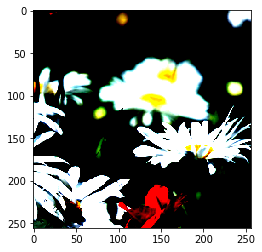

In [11]:
##---------------------------- Training and validation dataset------------------------##
print("==> [Preparing data ....]")

# Data augmentation and normalization for training
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(256),  # resize the image to 256*256 pixels
        transforms.CenterCrop(256),  # crop the image to 256*256 pixels about the center
        transforms.RandomHorizontalFlip(),  # convert the image to PyTorch Tensor data type
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.CenterCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
    # Just normalization for validation
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")


# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder("./flowers", data_transforms[x]) 
                  for x in ["train", "test", "val"]}

# Check
print(image_datasets["train"]) # training data
print(image_datasets["test"])  # test data
print(image_datasets["val"])   # val data
print(image_datasets["train"][0][0].shape)
training_img = image_datasets["train"][0][0].permute(1,2,0).numpy()
plt.imshow(training_img)
plt.show()

In [12]:
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=4) 
                    for x in ["train", "test", "val"]}
train_loader = dataloaders_dict["train"]
test_loader = dataloaders_dict["test"]
val_loader = dataloaders_dict["val"]

In [13]:
print('==> Bagnet-33 model')

##---- Load and modify model ----##
# model_name = "bagnet33"
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Check output layer matches number of output categories of our dataset.
print(model_ft.fc)

##---- Create the optimizer ----##
# Create the optimizer to update only desired parameters (only output layer in our case).
# Send the model to CPU
model_ft = model_ft.to(device)

#  Gather the parameters to be optimized/updated in this run. If we are finetuning we will be
#  updating all parameters. However, if we are doing feature extract method, we will only update
#  the parameters that we have just initialized, i.e. the parameters with requires_grad is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

==> Bagnet-33 model


Downloading: "https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet32-2ddd53ed.pth.tar" to /Users/ruiyan/.cache/torch/checkpoints/bagnet32-2ddd53ed.pth.tar
100%|██████████| 70.1M/70.1M [00:14<00:00, 5.12MB/s]


Linear(in_features=2048, out_features=5, bias=True)
Params to learn:
	 fc.weight
	 fc.bias


In [14]:
##---- Train and evaluate -----#
# Setup the loss fxn
print("[Using CrossEntropyLoss ...]")
criterion = nn.CrossEntropyLoss()

[Using CrossEntropyLoss ...]


In [15]:
# list(model_ft.children())

[Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [17]:
# try:
#     from torchsummary import summary
# except:
#     !pip3 install torchsummary
#     from torchsummary import summary
    
# summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             192
            Conv2d-2         [-1, 64, 222, 222]          36,864
       BatchNorm2d-3         [-1, 64, 222, 222]             128
              ReLU-4         [-1, 64, 222, 222]               0
            Conv2d-5         [-1, 64, 222, 222]           4,096
       BatchNorm2d-6         [-1, 64, 222, 222]             128
              ReLU-7         [-1, 64, 222, 222]               0
            Conv2d-8         [-1, 64, 110, 110]          36,864
       BatchNorm2d-9         [-1, 64, 110, 110]             128
             ReLU-10         [-1, 64, 110, 110]               0
           Conv2d-11        [-1, 256, 110, 110]          16,384
      BatchNorm2d-12        [-1, 256, 110, 110]             512
           Conv2d-13        [-1, 256, 111, 111]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [18]:
print("[Training the model begun ...]")
# model_ft, rhist = train_model(model_ft, dataloaders_dict, criterion,
#     optimizer_ft, num_epochs=num_epochs)

try:
    import torchbearer 
except:
    !pip3 install torchbearer
from torchbearer import Trial

start_epoch = 0
TOTAL_EPOCH = 40
INITIAL_LR = 4e-5

train_loss = []
train_acc = []
val_loss = []
val_acc = []
test_acc = []
test_loss = []

optimizer = optim.Adam(model_ft.parameters(), lr=INITIAL_LR)

tolerate = 0
best_val_acc = 0
patiance = 0

for i in range(start_epoch, TOTAL_EPOCH):
  print("Training starts: Epoch ", i)
  
  trial = Trial(model_ft, optimizer, criterion, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, val_generator=val_loader, test_generator=test_loader)
  trial.run(epochs=1)
  
  results_training = trial.evaluate(data_key=torchbearer.TRAIN_DATA)
  train_loss.append(results_training['train_loss'])
  train_acc.append(results_training['train_acc'])
  
  results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
  val_loss.append(results['val_loss'])
  val_acc.append(results['val_acc'])
  
  results_test = trial.evaluate(data_key=torchbearer.TEST_DATA)
  test_loss.append(results_test['test_loss'])
  test_acc.append(results_test['test_acc'])
  
  if results['val_acc'] >= best_val_acc:
    best_val_acc = results['val_acc']
    torch.save(model_ft.state_dict(), 'model_val%d.pt'%(best_val_acc*10000))
    print(" --------- New best validation acc --------- ", best_val_acc)
    patiance = 0
    
  else:
    tolerate += 1
    patiance += 1
    print("tolerate: ", tolerate, ", patiance: ", patiance)
  
  if tolerate >= 3:
    INITIAL_LR /= 2
    optimizer = optim.Adam(model_ft.parameters(), lr=INITIAL_LR)
    tolerate = 0
    print("New LR: ", INITIAL_LR)
    
  if patiance > 15:
    break
    print("Early stopping")

[Training the model begun ...]
Training starts: Epoch  0


KeyboardInterrupt: 

In [ ]:
print('model_val%d.pt'%(best_val_acc*10000))
model_ft.load_state_dict(torch.load('model_val%d.pt'%(best_val_acc*10000)))

results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
print(results)

In [ ]:
# Investigate the performance on the test data
predictions = trial.predict()
predicted_classes = predictions.argmax(1).cpu()
true_classes = [x for (_,x) in test_data.samples]
Index = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

from sklearn import metrics
CLASS = training_data.classes
print(metrics.classification_report(true_classes, predicted_classes, target_names=CLASS))

In [ ]:
# Plot loss and accuracy for bagnet33
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(9,4))
ax[0].plot(train_loss, label= "Train loss")
ax[0].plot(val_loss, label= "Val loss")
ax[0].plot(test_loss, label= "Test loss")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(train_acc, label= "Train acc")
ax[1].plot(val_acc, label= "Val acc")
ax[1].plot(test_acc, label= "Test acc")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()

In [ ]:
# Save validation accuray data
print("==> Saving validation accuracy data...")

out=open('model_val%d.txt'%(best_val_acc*10000), 'w')
out.write(str(train_loss) + "\n")
out.write(str(val_loss) + "\n")
out.write(str(test_loss) + "\n")
out.write(str(train_acc) + "\n")
out.write(str(val_acc) + "\n")
out.write(str(test_acc) + "\n")

out.close()

In [ ]:
# Save bagnet33 model
print("==> Saving model...")
torch.save({'model_bagnet33_state_dict': model_ft.state_dict(), 
            'optimizer_bagnet33_state_dict': optimizer_ft_.state_dict(), 
            'rhist' : rhist
           }, './saved_bagnet33.pth')